In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

# Define Horizontal and Vertical Edge filters

We have the Prewitt vertical edge detector 
\begin{equation*}
v = \begin{pmatrix} 1 & 0 & -1 \\ 1 & 0 & -1 \\ 1 & 0 & -1 \\ \end{pmatrix}\,.
\end{equation*}
Other options are
\begin{equation*}
v_{sobel} = \begin{pmatrix} 1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1 \\ \end{pmatrix}\,, \qquad \text{and} \qquad
v_{scharr} = \begin{pmatrix} 3 & 0 & -3\\ 10 & 0 & -10 \\ 3 & 0 & -3 \\ \end{pmatrix}\,.
\end{equation*}
The corresponding detectors for the horizontal edges are obtained by taking the transpose. 

Note that these are edge detectors for grayscale images which do not have a depth degree of freedom. The shape of these images is $\left(n_h,n_w\right)$.

In practice, the Scharr filter tends to retain more information about the original image while the Prewitt and Sobel filters extract the edges.

If the image is in color, it will have a depth as well, corresponding to the pixel intensities along the RGB channel. The shape of the image tensor will then be $\left(n_h,n_w,n_{ch}\right)$.

We will promote the above filters to RGB filters by simply copying them along the channel axis, i.e. if $v_{ijk}$ are the components of the 3d filter, where $k$ is the index along the channel direction, then
\begin{equation*}
v_{ijk} = v_{ij}
\end{equation*}
with $v_{ij}$ as above.

In [2]:
def filt2d(direction='vertical',case='prewitt'):
    if case == 'prewitt':
        filt = np.array([[1.,0.,-1.],[1.,0.,-1.],[1.,0.,-1.]])
    elif case == 'sobel':
        filt = np.array([[1.,0.,-1.],[2.,0.,-2.],[1.,0.,-1.]])
    elif case == 'scharr':
        filt = np.array([[3.,0.,-3.],[10.,0.,-10.],[3.,0.,-10.]])
    if direction == 'horizontal':
        filt = filt.T
    return filt

def make3d(filt2d):
    filt3d = np.repeat(filt2d[:,:,np.newaxis],3,axis=2)
    filt3d = np.expand_dims(filt3d,axis=-1)
    return filt3d

def imfilter(direction='vertical',case='prewitt', nch=2):
    filt = filt2d(direction=direction,case=case)
    if nch==3:
        filt = make3d(filt)
    return filt

def scale_img(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))

In [3]:
print(imfilter('horizontal','scharr'))
print(np.squeeze(imfilter(nch=3)))

[[  3.  10.   3.]
 [  0.   0.   0.]
 [ -3. -10. -10.]]
[[[ 1.  1.  1.]
  [ 0.  0.  0.]
  [-1. -1. -1.]]

 [[ 1.  1.  1.]
  [ 0.  0.  0.]
  [-1. -1. -1.]]

 [[ 1.  1.  1.]
  [ 0.  0.  0.]
  [-1. -1. -1.]]]


In [9]:
imfilter(nch=3).shape[1:3]

(3, 3)

# Open and Plot Image

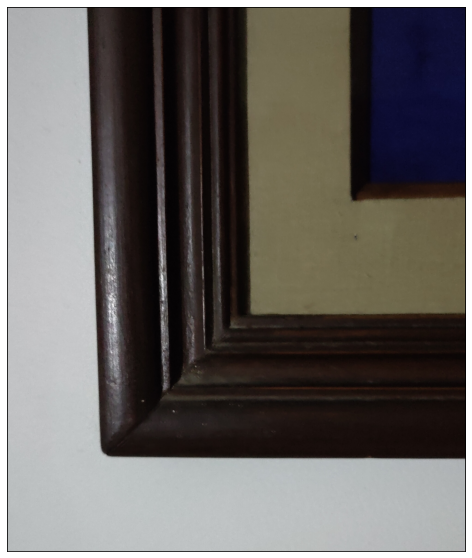

image shape: (2362, 1991, 3)


In [4]:
img = Image.open('frame.jpg')
img = np.asarray(img)
plt.figure(figsize=(10,10))
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
plt.imshow(img)
plt.show()

print('image shape:',img.shape)

# Pass filter over image using Tensorflow

In [5]:
def filter_image(img,filt,strides=1,padding='SAME'):
    '''wrapper for RGB img --> tf.nn.conv2D --> output tensor'''
    # expanding dim from (h,w,c) to (1,h,w,c)
    # because tf expects a minibatch, not a single img
    im = np.expand_dims(img,axis=0).astype('float32')
    output = tf.nn.conv2d(im.astype('float32'), filt, strides, padding).numpy()
    # squeezing output back to 3d from 4d to remove spurious minibatch axis
    output = np.squeeze(output)
    return output

def pretty_plot_filtered(img,output_vfilt,output_hfilt,figsize=(22,12),
                         cmap='viridis',scalev=True):
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=figsize)
    if scalev:
        axes[0].imshow(output_hfilt,vmin=0,vmax=255,cmap=cmap)
        axes[2].imshow(output_vfilt,vmin=0,vmax=255,cmap=cmap)
    else:
        axes[0].imshow(output_hfilt,cmap=cmap)
        axes[2].imshow(output_vfilt,cmap=cmap)
    axes[1].imshow(img.astype('int'),cmap=cmap)
    for ax in axes:
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                       labelleft=False, labelbottom=False)
    axes[0].set_xlabel('horizontal filter')
    axes[1].set_xlabel('original image')
    axes[2].set_xlabel('vertical filter')
    plt.show()

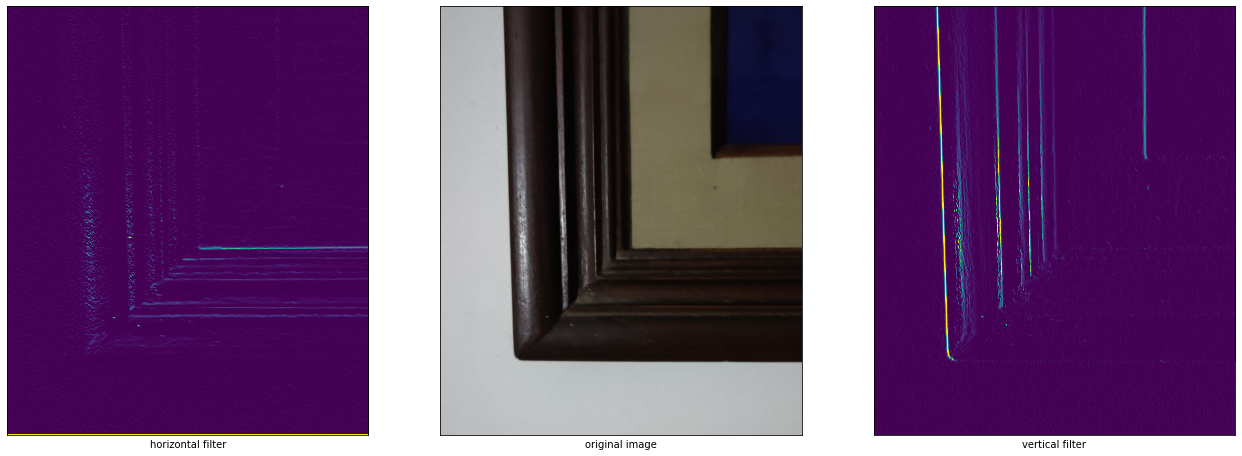

In [6]:
vfilt = imfilter(nch=3)
output_vfilt = filter_image(img,vfilt)

hfilt = imfilter(direction ='horizontal',nch=3)
output_hfilt = filter_image(img,hfilt)

pretty_plot_filtered(img,output_vfilt,output_hfilt,scalev=True)

We see that the horizontal lines tend to activate the horizontal filter more strongly, while the vertical lines activate the vertical filter.

## Compare with Sobel and Scharr Filters

SOBEL FILTER


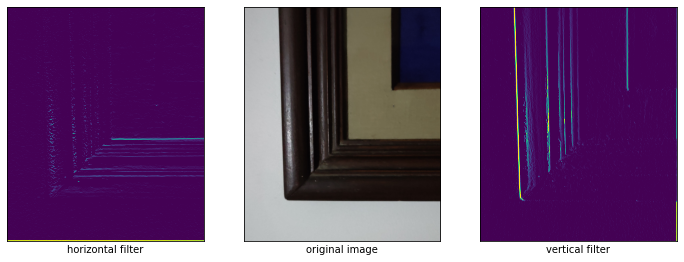

SCHARR FILTER


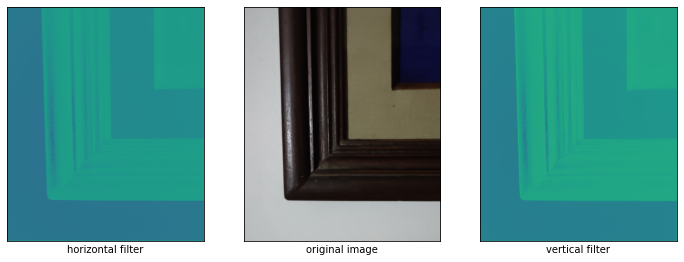

In [8]:
img = Image.open('frame.jpg')
img = np.asarray(img)

vfilt = imfilter(case='sobel',nch=3)
output_vfilt = filter_image(img,vfilt)

hfilt = imfilter(direction ='horizontal',case='sobel',nch=3)
output_hfilt = filter_image(img,hfilt)

print('SOBEL FILTER')
pretty_plot_filtered(img,output_vfilt,output_hfilt,figsize=(12,8))

vfilt = imfilter(case='scharr',nch=3)
output_vfilt = filter_image(img,vfilt)

hfilt = imfilter(direction ='horizontal',case='scharr',nch=3)
output_hfilt = filter_image(img,hfilt)

print('SCHARR FILTER')
pretty_plot_filtered(img,output_vfilt,output_hfilt,figsize=(12,8),scalev=False)

# Other Images

Typically images do not have such strong vertical and horizontal features. We will pass the above filters through more general shapes to see that they still act
as edge detectors.

PREWITT FILTER


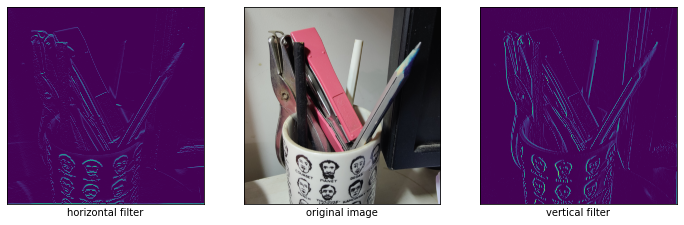

SOBEL FILTER


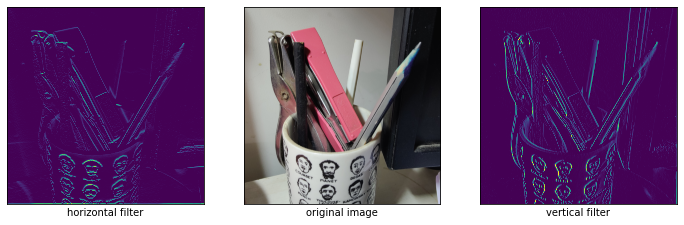

SCHARR FILTER


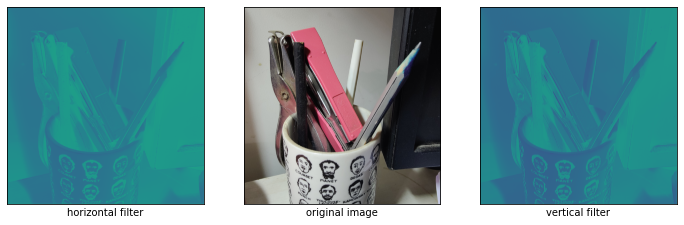

In [9]:
img = Image.open('desk.jpg')
img = np.asarray(img)

vfilt = imfilter(nch=3)
output_vfilt = filter_image(img,vfilt)

hfilt = imfilter(direction ='horizontal',nch=3)
output_hfilt = filter_image(img,hfilt)

print('PREWITT FILTER')
pretty_plot_filtered(img,output_vfilt,output_hfilt,figsize=(12,8))

vfilt = imfilter(case='sobel',nch=3)
output_vfilt = filter_image(img,vfilt)

hfilt = imfilter(direction ='horizontal',case='sobel',nch=3)
output_hfilt = filter_image(img,hfilt)

print('SOBEL FILTER')
pretty_plot_filtered(img,output_vfilt,output_hfilt,figsize=(12,8))

vfilt = imfilter(case='scharr',nch=3)
output_vfilt = filter_image(img,vfilt)

hfilt = imfilter(direction ='horizontal',case='scharr',nch=3)
output_hfilt = filter_image(img,hfilt)

print('SCHARR FILTER')
pretty_plot_filtered(img,output_vfilt,output_hfilt,figsize=(12,8),scalev=False)

PREWITT FILTER


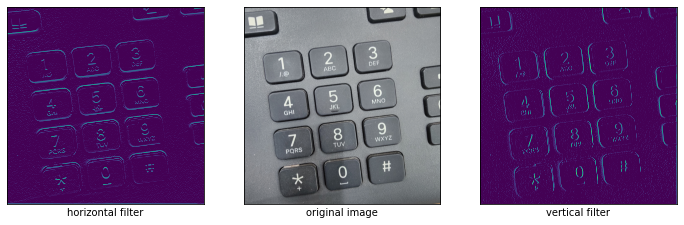

SOBEL FILTER


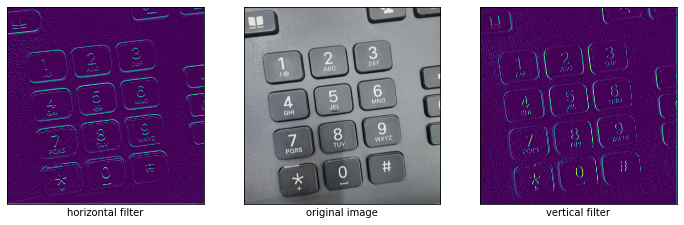

SCHARR FILTER


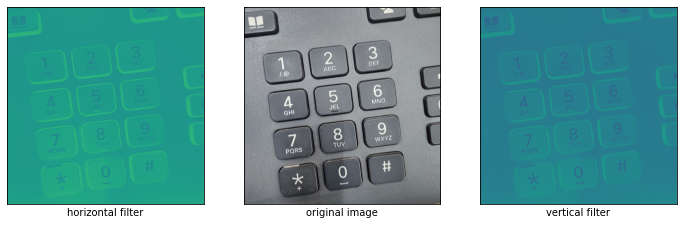

In [10]:
img = Image.open('phone1.jpg')
img = np.asarray(img)

vfilt = imfilter(nch=3)
output_vfilt = filter_image(img,vfilt)

hfilt = imfilter(direction ='horizontal',nch=3)
output_hfilt = filter_image(img,hfilt)

print('PREWITT FILTER')
pretty_plot_filtered(img,output_vfilt,output_hfilt,figsize=(12,8))

vfilt = imfilter(case='sobel',nch=3)
output_vfilt = filter_image(img,vfilt)

hfilt = imfilter(direction ='horizontal',case='sobel',nch=3)
output_hfilt = filter_image(img,hfilt)

print('SOBEL FILTER')
pretty_plot_filtered(img,output_vfilt,output_hfilt,figsize=(12,8))

vfilt = imfilter(case='scharr',nch=3)
output_vfilt = filter_image(img,vfilt)

hfilt = imfilter(direction ='horizontal',case='scharr',nch=3)
output_hfilt = filter_image(img,hfilt)

print('SCHARR FILTER')
pretty_plot_filtered(img,output_vfilt,output_hfilt,figsize=(12,8),scalev=False)